# Conceptual Saliency

Welcome to the **Conceptual Saliency** notebook! This project aims to apply Formal Concept Analysis (FCA) algorithms to a dataset and analyse the resulting visualizations using saliency mapping techniques.

## Overview

Formal Concept Analysis (FCA) is a mathematical technique used for data analysis, knowledge representation, and information retrieval. By using FCA, we can extract meaningful patterns and relationships from complex datasets. Saliency mapping, on the other hand, helps in identifying the most significant parts of a visualisation, aiding in better interpretation and insights.

## Project Goals

- Implement and test various FCA algorithms on different datasets.
- Generate visualizations of the concept lattices and other FCA structures.
- Apply saliency mapping techniques to these visualizations to highlight key insights.
- Analyse and document the outcomes to refine the workflow and improve results.

## Reference Libraries

Python libraries that I will try:
- For Formal Concept Analysis: [https://github.com/EgorDudyrev/FCApy](https://github.com/EgorDudyrev/FCApy) a python package to work with Formal Concept Analysis.
- For Saliency mapping:
  - [https://github.com/pair-code/saliency](https://github.com/pair-code/saliency)
  - [https://github.com/matthias-k/pysaliency](https://github.com/matthias-k/pysaliency) analyzing and modeling of eye movement

## Reference Datasets

Datasets I will use for testing:
- The Tate Collection: [https://github.com/tategallery/collection](https://github.com/tategallery/collection) starting from some pre-processed data already available here [https://github.com/SPARQL-Anything/showcase-tate](https://github.com/SPARQL-Anything/showcase-tate) 

## Data Preparation

In order to apply FCA methods, the library needs a matrix as input, such as this one

In [ ]:
'''
,fly,hunt,run,swim
dove,True,False,False,False
hen,False,False,False,False
duck,True,False,False,True
goose,True,False,False,True
owl,True,True,False,False
hawk,True,True,False,False
eagle,True,True,False,False
fox,False,True,True,False
dog,False,False,True,False
wolf,False,True,True,False
cat,False,True,True,False
tiger,False,True,True,False
lion,False,True,True,False
horse,False,False,True,False
zebra,False,False,True,False
cow,False,False,False,False
'''

Understanding how to generalise this passage will be subject of further discussion. However, for the time being, I will create a binary matrix `artworkId x subjectName` starting from subjects.csv and subjects-artworks-id.csv files available [here](https://github.com/SPARQL-Anything/showcase-tate).
Namely,

In [ ]:
# subjects.csv
'''
subjectId,subjectName
,
1,subject
4,group/movement
13,architecture
14,agricultural
15,bridges and viaducts
17,features
18,garden structures
19,industrial
20,military
21,monuments
22,periods and styles
23,places of entertainment
24,public and municipal
25,religious
26,residential
...
'''

# subjects-artworks-id.csv
'''
subjectId,artworkId
25,5700
13,5748
4537,8416
92,15718
1519,23478
29,15699
166,105988
92,10108
78,7214
91,23699
14439,20199
...
'''

I will:
1. **Load the CSV files** into data frames.
2. **Filter** the `subjects-artworks-id.csv` dataframe to include only rows where the `subjectId` is between 1 and 100.
3. **Merge** the filtered dataframe with the `subjects.csv` dataframe on the `subjectId` to get the corresponding `subjectName`.
4. **Create the binary matrix** with `artworkId` as rows and `subjectName` as columns, with True or False values.

In [1]:
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice
from fcapy.visualizer import LineVizNx
import os
import pandas as pd
import networkx as nx
from anytree import Node, RenderTree
import matplotlib.pyplot as plt

c:\Users\giuli\Desktop\conceptual-saliency\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Subjects are organised in a hierarchy. I first decided on the level of depth to use (see subject_hierarchy.ipynb). Now I want to substitute all subjects that go dipeere than that with the set I decided on.

In [2]:
# Load the uploaded CSV file to examine its content
file_path = 'https://raw.githubusercontent.com/SPARQL-Anything/showcase-tate/main/hierarchy.csv'
hierarchy_df = pd.read_csv(file_path)

# Fill NA values in ID columns with a placeholder (e.g., -1) or remove them
hierarchy_df = hierarchy_df.dropna(subset=['childId', 'parentId'])

# Convert the ID columns to integers
hierarchy_df['childId'] = hierarchy_df['childId'].astype(int)
hierarchy_df['parentId'] = hierarchy_df['parentId'].astype(int)

# Function to detect and remove cycles in the graph
def remove_cycles(df):
    G = nx.DiGraph()
    for _, row in df.iterrows():
        G.add_edge(row['parentId'], row['childId'])
    
    try:
        while True:
            cycle = nx.find_cycle(G, orientation='original')
            for parent_id, child_id, _ in cycle:
                if G.has_edge(parent_id, child_id):
                    G.remove_edge(parent_id, child_id)
    except nx.NetworkXNoCycle:
        pass
    
    edges = list(G.edges)
    return pd.DataFrame(edges, columns=['parentId', 'childId'])

# Remove cycles from the dataframe
filtered_hierarchy_df = remove_cycles(hierarchy_df)

# Create a tree from the dataframe including only IDs
def create_tree_with_only_ids(df):
    nodes = {}
    for _, row in df.iterrows():
        child_id = row['childId']
        parent_id = row['parentId']
        
        if parent_id not in nodes:
            nodes[parent_id] = Node(parent_id)
        
        if child_id not in nodes:
            nodes[child_id] = Node(child_id, parent=nodes[parent_id])
        else:
            nodes[child_id].parent = nodes[parent_id]
    return nodes

# Function to render the tree up to a certain depth with only IDs
def render_tree_with_only_ids(root, max_depth):
    tree_text = "\n".join([f"{pre}{node.name}" for pre, _, node in RenderTree(root) if node.depth <= max_depth])
    return tree_text

# Create the tree with only IDs after removing cycles
nodes_with_only_ids = create_tree_with_only_ids(filtered_hierarchy_df)

# Find the root node (the one without a parent)
root_with_only_ids = next(node for node in nodes_with_only_ids.values() if node.is_root)

# Render the tree up to a specified depth (e.g., 2) with only IDs
tree_text_with_only_ids = render_tree_with_only_ids(root_with_only_ids, max_depth=2)
# print(tree_text_with_only_ids)

# Function to find the ancestor at max depth 2
def find_ancestor_at_max_depth_2(node, max_depth=2):
    while node.depth > max_depth:
        node = node.parent
    return node

# Process the subjects-artworks relationships
def process_subjects_artworks(df, tree_root, max_depth=2):
    # Initialize an empty dictionary to hold the mapping of node names to node objects
    id_to_node = {}

    # Iterate over each node in the RenderTree starting from tree_root
    for row in RenderTree(tree_root):
        node = row.node
        # Add the node to the dictionary with the node's name as the key and the node object as the value
        id_to_node[node.name] = node
    def get_substitute_id(subject_id):
        if subject_id in id_to_node:
            node = id_to_node[subject_id]
            if node.depth > max_depth:
                ancestor = find_ancestor_at_max_depth_2(node, max_depth)
                return ancestor.name
        return subject_id
    
    df['substituted_subjectId'] = df['subjectId'].apply(get_substitute_id)
    return df

In [3]:
# load subjects-artworks relationships
subjects_artworks_df = pd.read_csv('https://raw.githubusercontent.com/SPARQL-Anything/showcase-tate/main/subjects-artworks-id.csv')
# Process the subjects-artworks relationships
subjects_artworks_df = process_subjects_artworks(subjects_artworks_df, root_with_only_ids, max_depth=2)
    
# Set display options to show all rows and columns
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
print(subjects_artworks_df)

        subjectId  artworkId  substituted_subjectId
0              25       5700                     25
1              13       5748                     13
2            4537       8416                     44
3              92      15718                     92
4            1519      23478                     73
...           ...        ...                    ...
839427         22       6267                     22
839428        106      46310                    106
839429        145      46866                    145
839430        496       7098                     71
839431        189       2325                    189

[839432 rows x 3 columns]


Keep Only substituted_subjectId Column and Rename It

In [4]:
updated_subjects_artworks_df = subjects_artworks_df.drop(columns=['subjectId'])
updated_subjects_artworks_df = updated_subjects_artworks_df.rename(columns={'substituted_subjectId': 'subjectId'})
print(updated_subjects_artworks_df)

        artworkId  subjectId
0            5700         25
1            5748         13
2            8416         44
3           15718         92
4           23478         73
...           ...        ...
839427       6267         22
839428      46310        106
839429      46866        145
839430       7098         71
839431       2325        189

[839432 rows x 2 columns]


In [5]:
# load subjects
subjects_df = pd.read_csv('https://raw.githubusercontent.com/SPARQL-Anything/showcase-tate/main/subjects.csv')

# Filter the subjects_artworks_df to include only subjectId between 1 and 100
# filtered_subjects_artworks_df = subjects_artworks_df[(subjects_artworks_df['subjectId'] >= 1) & (subjects_artworks_df['subjectId'] <= 100)]
# Merge the filtered dataframe with the subjects dataframe on subjectId
merged_df = pd.merge(updated_subjects_artworks_df, subjects_df, on='subjectId')

# Display the final dataframe
print(len(merged_df))
print(merged_df)

839432
        artworkId  subjectId                    subjectName
0            5700         25                      religious
1            5748         13                   architecture
2            8416         44           public and municipal
3           15718         92  actions: postures and motions
4           23478         73           seascapes and coasts
...           ...        ...                            ...
839427       6267         22             periods and styles
839428      46310        106                         places
839429      46866        145                        society
839430       7098         71                      landscape
839431       2325        189      from recognisable sources

[839432 rows x 3 columns]


In [6]:
# create the binary matrix with True/False values

# ensure the results directory exists
results_dir = '../results'
output_file_path = os.path.join(results_dir, 'artwork_subject_binary_matrix.csv')

# Set artworkId as the index for merged_df
merged_df.set_index('artworkId', inplace=True)
# Create a pivot table with artworkId as rows and subjectName as columns
pivot_df = merged_df.pivot_table(index='artworkId', columns='subjectName', aggfunc=lambda x: True, fill_value=False)

# Drop the 'subjectId' level from the columns
pivot_df.columns = pivot_df.columns.droplevel()
pivot_df.index.name = None  # Remove index name for similarity to the provided example
# # Convert the values to boolean (True for presence, False for absence)
# pivot_df = pivot_df.applymap(lambda x: True if x > 0 else False)

# Display the final pivot table
print(pivot_df)

# Save the pivot_df as a CSV file
pivot_df.to_csv(output_file_path)

subjectName  21st century  Bible: New Testament  Bible: Old Testament  \
3                   False                 False                 False   
4                   False                 False                 False   
5                   False                 False                 False   
7                   False                 False                 False   
8                   False                 False                 False   
...                   ...                   ...                   ...   
127129              False                 False                 False   
127130              False                 False                 False   
127131              False                 False                 False   
127717              False                 False                 False   
129068              False                 False                 False   

subjectName  Judaeo-Christian imagery  Saints  Shakespeare  UK London  \
3                               False   False     

## Formal Context

In [7]:
results_dir = '../results'
output_file_path = os.path.join(results_dir, 'artwork_subject_binary_matrix.csv')
# load the CSV file and ensure the index (artworkId) is of type str
df = pd.read_csv(output_file_path, index_col=0)
df.index = df.index.map(str)

# Create the FormalContext
K = FormalContext.from_pandas(df)
K.write_csv('../results/artwork_subject_context.csv', sep=',')


# Print the first five objects data
print(len(K))
print('# objects', K.n_objects, '; # attributes', K.n_attributes)
print(K[:5])

58800
# objects 58800 ; # attributes 160
FormalContext (5 objects, 160 attributes, 42 connections)
 |21st century|Bible: New Testament|Bible: Old Testament|Judaeo-Christian imagery|Saints|...|weapons|weather|work and occupations|workspaces|world religions|
3|            |                    |                    |                        |      |...|       |       |                    |          |               |
4|            |                    |                    |                        |      |...|       |      X|                    |          |               |
5|            |                    |                    |                        |      |...|       |       |                   X|          |               |
7|            |                    |                    |                        |      |...|       |       |                    |          |               |
8|            |                    |                    |                        |      |...|       |       |  

In [34]:
print(len(K.extension( ['landscape', 'water: inland'] )))

8028


In [27]:
print(K.intention( ['767'] ))

['architecture', 'cities, towns, villages (non-UK)', 'countries and continents', 'periods and styles', 'places', 'religious', 'townscapes, man-made features']


## Concept Lattice

In [8]:
# create the concept lattice
L = ConceptLattice.from_context(K, algo='Sofia', L_max = 1000, min_supp = 0.1, use_tqdm=True)
L.write_json(objs_order=K.object_names, attrs_order=K.attribute_names, path='../results/artwork_subject_concept.json')
print("# concepts:", len(L))

Iter. Sofia projections:   0%|          | 0/160 [00:00<?, ?it/s]

Iter. Sofia projections: 100%|██████████| 160/160 [00:00<00:00, 261.61it/s]


# concepts: 87


In [9]:
intent_set = set()
for i, c in enumerate(L):
    print(f"Concept {i} {c.intent}:\nextent {len(c.extent)}\nintent {len(c.intent)}\n")
    intent_set.add(len(c.intent))

Concept 0 ():
extent 58800
intent 0

Concept 1 ('nature',):
extent 36486
intent 1

Concept 2 ('architecture',):
extent 29787
intent 1

Concept 3 ('places',):
extent 23842
intent 1

Concept 4 ('landscape', 'nature'):
extent 23323
intent 2

Concept 5 ('architecture', 'nature'):
extent 22715
intent 2

Concept 6 ('people',):
extent 20800
intent 1

Concept 7 ('adults', 'people'):
extent 19158
intent 2

Concept 8 ('nature', 'places'):
extent 18709
intent 2

Concept 9 ('architecture', 'places'):
extent 18618
intent 2

Concept 10 ('architecture', 'townscapes, man-made features'):
extent 18499
intent 2

Concept 11 ('architecture', 'landscape', 'nature'):
extent 15963
intent 3

Concept 12 ('architecture', 'nature', 'places'):
extent 14589
intent 3

Concept 13 ('architecture', 'nature', 'townscapes, man-made features'):
extent 14470
intent 3

Concept 14 ('society',):
extent 14011
intent 1

Concept 15 ('landscape', 'nature', 'places'):
extent 13186
intent 3

Concept 16 ('objects',):
extent 12381
i

In [10]:
temp_list = list(intent_set)
temp_list.pop()
intent_unique_values = set(temp_list)

### Visualisation

In [11]:
figsize = (10, 10)
dpi_for_compare_image = 300
dpi_for_process = 600

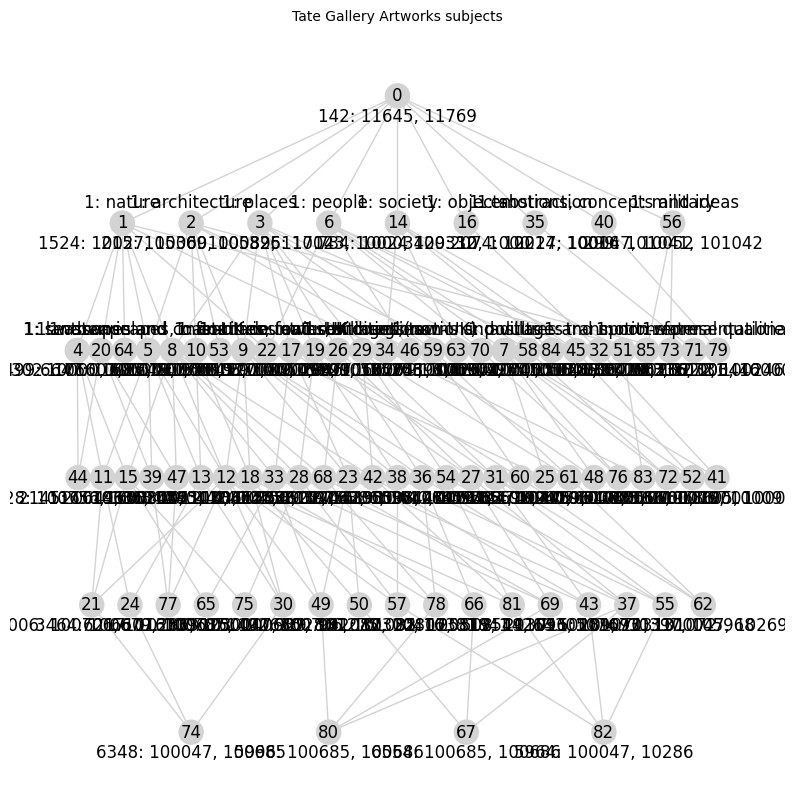

In [60]:
fig, ax = plt.subplots(figsize=figsize)
vsl = LineVizNx()
vsl.draw_concept_lattice(L, ax=ax, flg_drop_bottom_concept=True, flg_node_indices=True)
ax.set_title('Tate Gallery Artworks subjects', fontsize=10)
plt.show()
plt.close()

In [13]:
# Normalize the values to a range between 0 and 1
min_val = min(intent_unique_values)
max_val = max(intent_unique_values)
normalized_values = [(val - min_val) / (max_val - min_val) for val in intent_unique_values]

# Adjust the range to avoid pure black
def adjust_to_avoid_black(norm_val):
    return 0.0 + 0.6 * norm_val  # Adjusting the range to be from white to 60% gray

adjusted_values = [adjust_to_avoid_black(val) for val in normalized_values]

# Create a dictionary mapping each number to a corresponding gray intensity
gray_map = {val: f"#{int((1 - adj_val) * 255):02x}{int((1 - adj_val) * 255):02x}{int((1 - adj_val) * 255):02x}" for val, adj_val in zip(intent_unique_values, adjusted_values)}

print(gray_map)

{0: '#ffffff', 1: '#e0e0e0', 2: '#c1c1c1', 3: '#a3a3a3', 4: '#848484', 5: '#666666'}


In [14]:
from copy import deepcopy
L_clr = deepcopy(L)

# color
node_color = []
extent_intensity = []
for c in L_clr:
    if len(c.extent) != 0:
        color = gray_map[len(c.intent)]
        node_color.append(color)
        extent_len = len(c.extent)
        extent_intensity.append(extent_len)

print('COLORS: ', node_color)
print('SIZE: ', extent_intensity)

COLORS:  ['#ffffff', '#e0e0e0', '#e0e0e0', '#e0e0e0', '#c1c1c1', '#c1c1c1', '#e0e0e0', '#c1c1c1', '#c1c1c1', '#c1c1c1', '#c1c1c1', '#a3a3a3', '#a3a3a3', '#a3a3a3', '#e0e0e0', '#a3a3a3', '#e0e0e0', '#c1c1c1', '#a3a3a3', '#c1c1c1', '#c1c1c1', '#848484', '#c1c1c1', '#a3a3a3', '#848484', '#a3a3a3', '#c1c1c1', '#a3a3a3', '#a3a3a3', '#c1c1c1', '#848484', '#a3a3a3', '#c1c1c1', '#a3a3a3', '#c1c1c1', '#e0e0e0', '#a3a3a3', '#848484', '#a3a3a3', '#a3a3a3', '#e0e0e0', '#a3a3a3', '#a3a3a3', '#848484', '#a3a3a3', '#c1c1c1', '#c1c1c1', '#a3a3a3', '#a3a3a3', '#848484', '#848484', '#c1c1c1', '#a3a3a3', '#c1c1c1', '#a3a3a3', '#848484', '#e0e0e0', '#848484', '#c1c1c1', '#c1c1c1', '#a3a3a3', '#a3a3a3', '#848484', '#c1c1c1', '#c1c1c1', '#848484', '#848484', '#666666', '#a3a3a3', '#848484', '#c1c1c1', '#c1c1c1', '#a3a3a3', '#c1c1c1', '#666666', '#848484', '#a3a3a3', '#848484', '#848484', '#c1c1c1', '#666666', '#848484', '#666666', '#a3a3a3', '#c1c1c1', '#c1c1c1']
SIZE:  [58800, 36486, 29787, 23842, 23323, 2

In [69]:
# size
# Normalize the values to a range between min_size and max_size
min_val = min(extent_intensity)
max_val = max(extent_intensity)

# Avoid division by zero if all values are the same
if max_val != min_val:
    normalized_values = [(val - min_val) / (max_val - min_val) for val in extent_intensity]
else:
    normalized_values = [0.5] * len(extent_intensity)  # If all values are the same, set them to the midpoint size

node_sizes = [min_val + norm_val * (max_val - min_val) for norm_val in normalized_values]

In [204]:
fig, ax = plt.subplots(figsize=(80,80))
vsl.draw_concept_lattice(L_clr, ax=ax, flg_node_indices=True, node_label_func=None,
    flg_new_intent_count_prefix=True, flg_drop_bottom_concept=True, node_color='#e0e0e0', node_size=node_sizes, edge_size=10, edge_color='#a3a3a3', fontsize=500)
plt.savefig('../results/lattice/to_compare.png')
plt.close()
# colour: number of attributes (white=0)
# size: number of subjects (the smaller the lesser)

In [136]:
fig, ax = plt.subplots(figsize=(80,80))
vsl.draw_concept_lattice(L_clr, ax=ax, flg_node_indices=False, node_label_func=None,
    flg_new_intent_count_prefix=False, flg_drop_bottom_concept=True, node_color=node_color, node_size=node_sizes, edge_size=10, edge_color='#e0e0e0')
plt.savefig('../results/lattice/to_process.png')
plt.close()


Scatterplot with artworks on the x-axis and subjects on the y-axis

In [103]:
# This is an alternative solution for the scatterplot that has number of subjects per concept (extent) in the x, 
# and a correlation per concept betweeen (number of attributes/ same tuple of attributes in how many concepts) in the y.

# import pprint

# scatterplot_data = {}
# for i, c in enumerate(L):
#     attributes_and_concepts = {}
#     n_concepts = 1 # for sure ther is itself

#     attributes = list(c.intent)
#     attributes_and_concepts['attributes'] = attributes
#     attributes_and_concepts['n_attributes'] = len(attributes)
#     attributes_and_concepts['n_subjects'] = len(c.extent)

#     for index, other_c in enumerate(L):
#         if set(attributes).issubset(list(other_c.intent)):
#             n_concepts +=1
    
#     attributes_and_concepts['concepts_per_intent'] = n_concepts
#     scatterplot_data[i] = attributes_and_concepts

# pprint.pprint(scatterplot_data)



In [104]:
# x = []
# y = []

# for k, v in scatterplot_data.items():
#     if v['n_attributes'] != 0 and v['n_subjects'] != 0:
#         x.append(v['n_subjects'])
#         y.append(v['n_attributes'] / v['concepts_per_intent'])

# # Plotting the scatter plot
# plt.scatter(x, y)
# plt.xlabel('n_subjects')
# plt.ylabel('n_attributes / concepts_per_intent')
# plt.title('Scatter plot of n_subjects vs n_attributes/concepts_per_intent')
# plt.show()

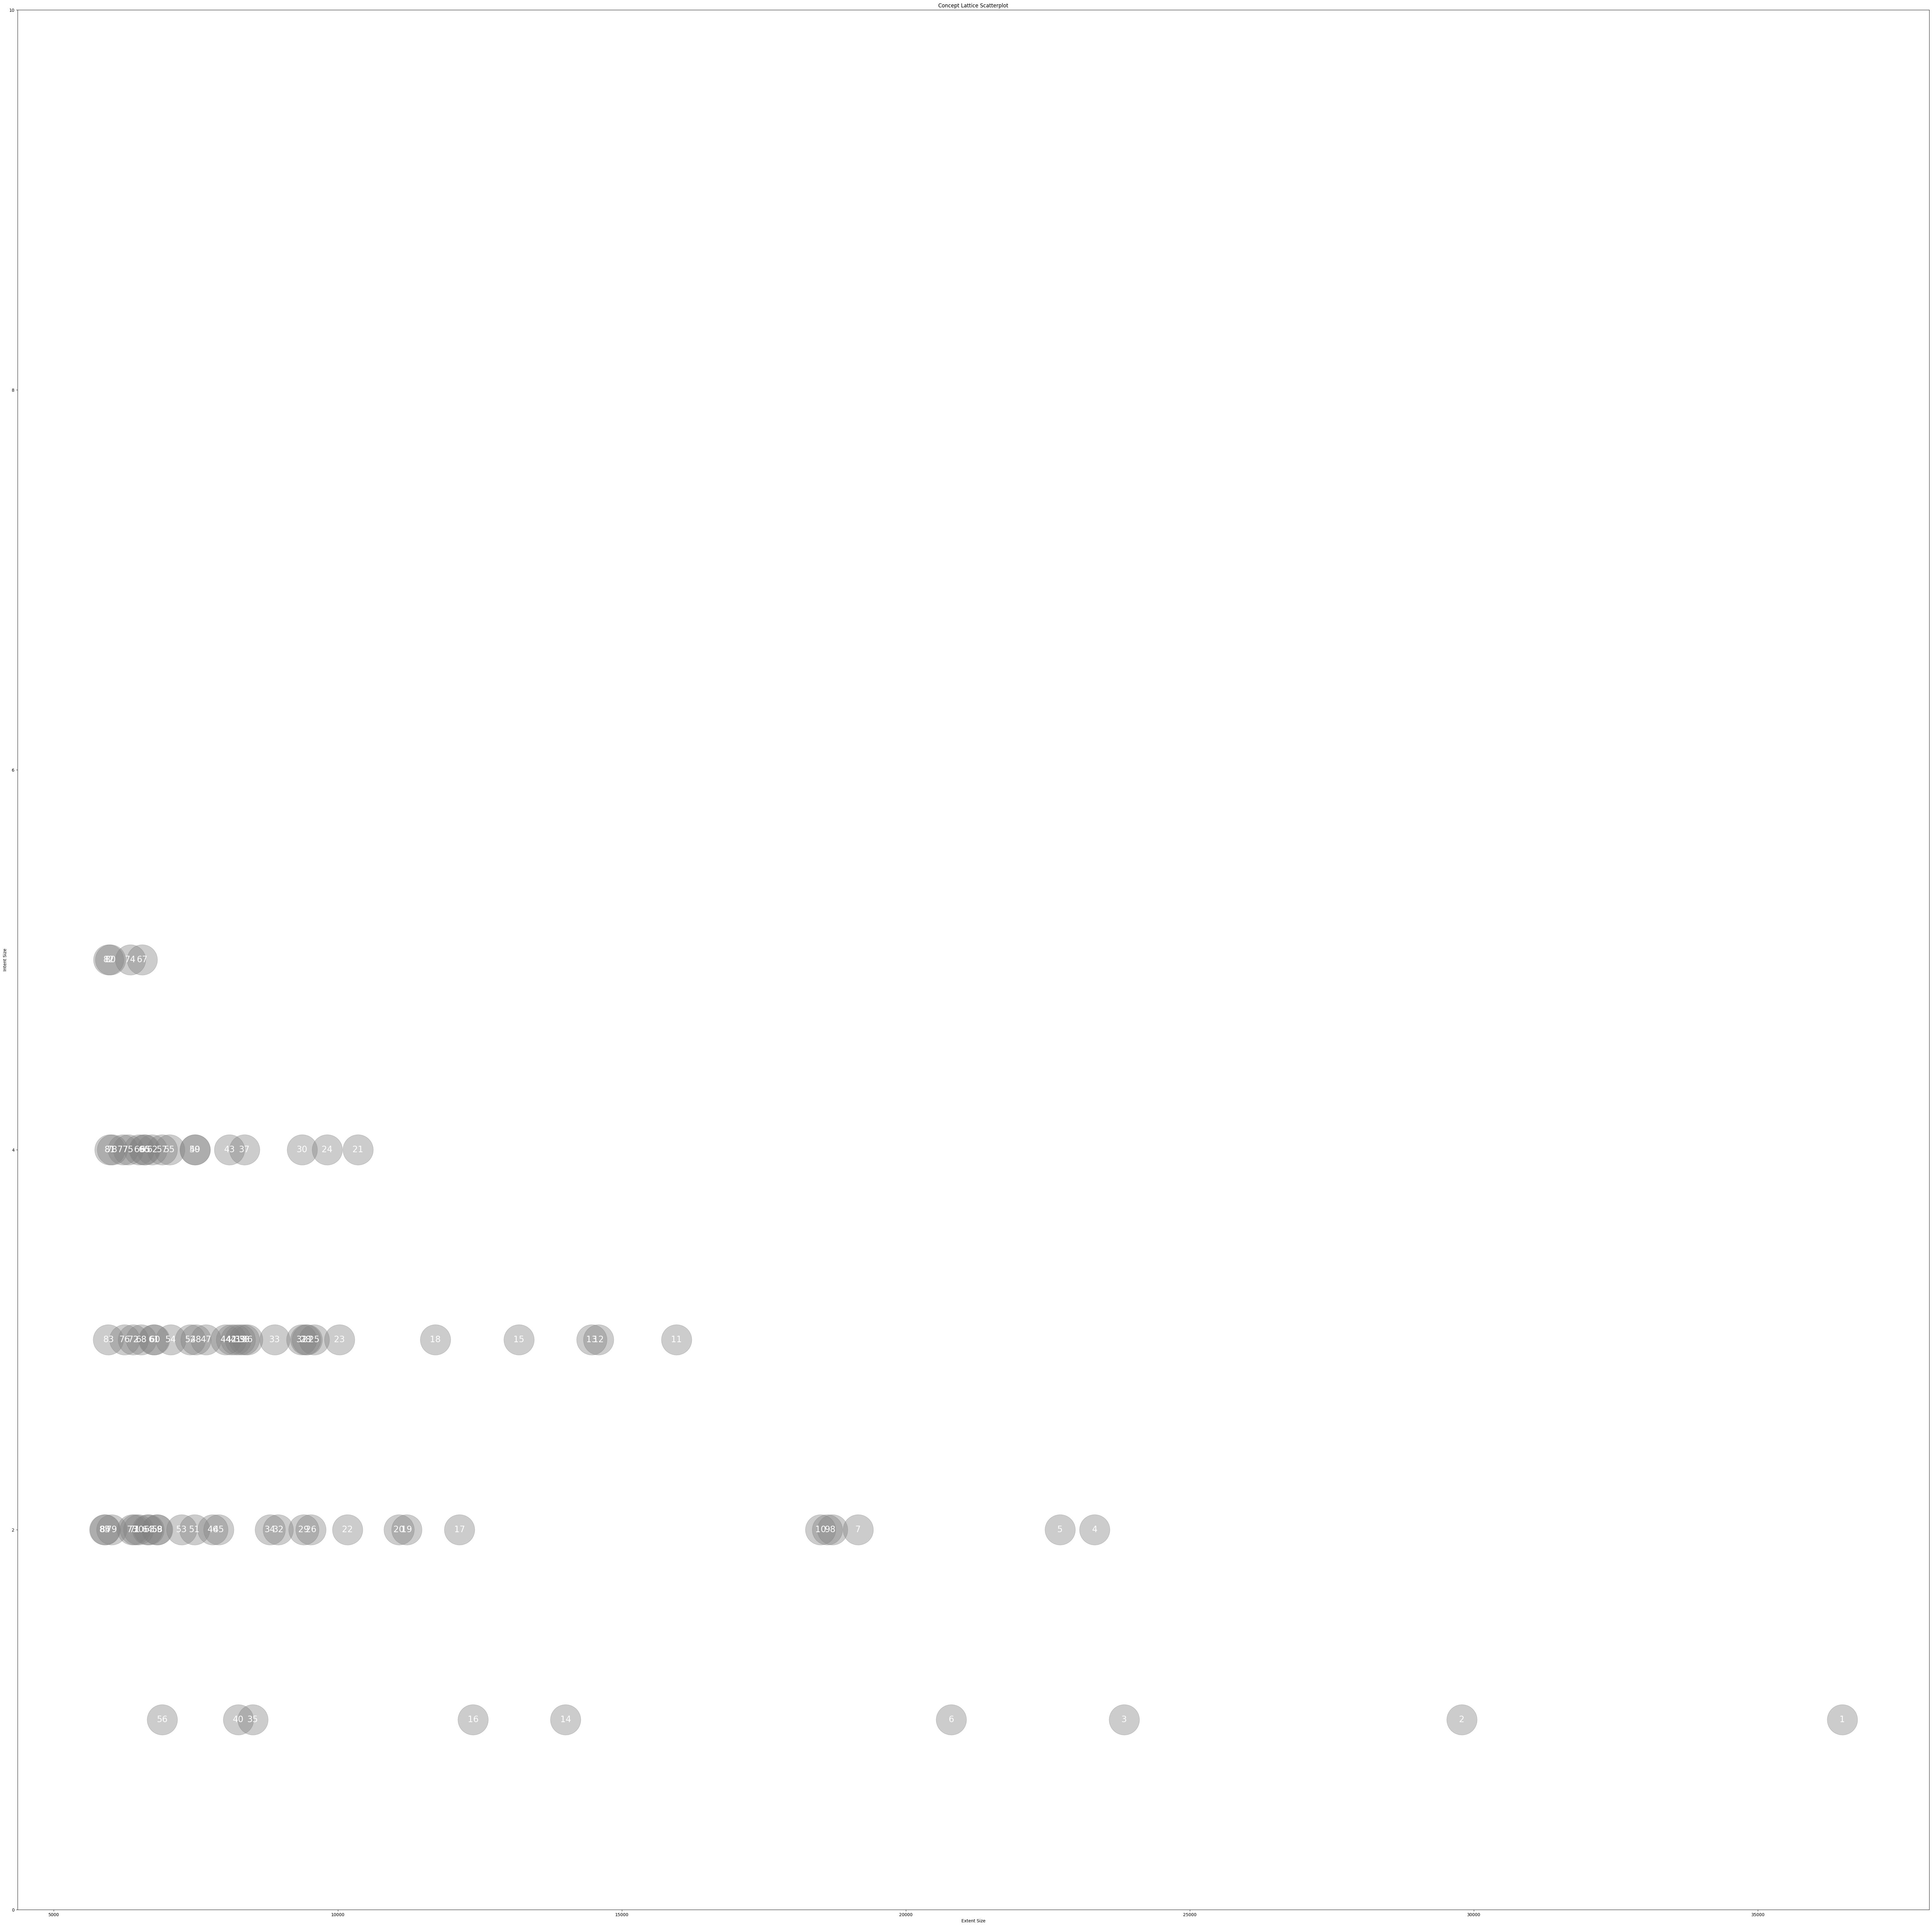

In [176]:
# Plotting the concept lattice as a scatterplot
# Extract concepts and assign coordinates (for simplicity, we'll use their index as coordinates)
# concepts = [(i, len(concept.extent), len(concept.intent)) for i, concept in enumerate(L)]
# if we don't want intent/extent = 0
concepts = [(i, len(concept.extent), len(concept.intent)) for i, concept in enumerate(L) if len(concept.extent) != 0 and len(concept.intent) != 0]

# Separate the coordinates for plotting
indices, x_coords, y_coords = zip(*concepts)

# Create scatter plot
fig, ax = plt.subplots(figsize=(80, 80))
scatter = ax.scatter(x_coords, y_coords, c='0.5', s=5000, alpha=0.4) # I can play with alpha for blending and c for the shade of gray
ax.set_xlabel('Extent Size')
ax.set_ylabel('Intent Size')
ax.set_title('Concept Lattice Scatterplot')

ax.set_ylim(0, 10)
# Annotate points with their index
for i, x, y in concepts:
    ax.text(x, y, str(i), fontsize=20, ha='center', va='center', color='white')
plt.show()

In [178]:
# plot without grid
# Create scatter plot
fig, ax = plt.subplots(figsize=(80, 80))
scatter = ax.scatter(x_coords, y_coords, s=0, c='0.5', alpha=0.4) # I can play with alpha for blending and c for the shade of gray
# # Annotate points with their index
for i, x, y in concepts:
    ax.text(x, y, str(i), fontsize=20, ha='center', va='center', color='black')
ax.set_ylim(0, 10)
# for k, v in scatterplot_data.items():
#     if v['n_attributes'] != 0 and v['n_subjects'] != 0:
#         ax.text(v['n_subjects'], v['n_attributes'] / v['concepts_per_intent'], str(k), fontsize=5, ha='center', va='center', color='black')
# Remove axes
ax.axis('off')
plt.savefig('../results/scatterplot/to_compare.png')
plt.close()

In [180]:
# plot without grid and labels
# Create scatter plot
fig, ax = plt.subplots(figsize=(80, 80))
scatter = ax.scatter(x_coords, y_coords, s=5000, c='0.5', alpha=0.4) # I can play with alpha for blending and c for the shade of gray
ax.set_ylim(0, 10)
# Remove axes
ax.axis('off')
plt.savefig('../results/scatterplot/to_process.png')
plt.close()

### Barchart Concepts-X, Intent-Y and Extent-Width

[1.0, 0.8163953297155073, 0.6534561201556761, 0.6392314860494436, 0.6225675601600614, 0.5700816751630763, 0.5250781121526065, 0.5127720221454805, 0.510277914816642, 0.5070163898481609, 0.4375102779148166, 0.39985199802664034, 0.3965904730581593, 0.3840103053225895, 0.3613988927259771, 0.33933563558625224, 0.33278517787644574, 0.3211368744175848, 0.3072685413583292, 0.30354108425149373, 0.2837800800306967, 0.2787096420544867, 0.274899961629118, 0.26892506714904346, 0.26262127939483637, 0.26108644411555115, 0.25933234665351096, 0.2584827056953352, 0.25763306473715947, 0.25689305487036124, 0.25661897714191745, 0.2453543825028778, 0.24362769281368196, 0.24138025544044292, 0.2330482924957518, 0.23049936962122458, 0.22907416543331688, 0.22896453434193936, 0.22696376692429973, 0.22605931042043523, 0.22493559173381572, 0.22268815436057665, 0.22183851340240093, 0.22002960039467193, 0.21654881324343583, 0.21372581264046484, 0.21049169544482815, 0.20553088855999563, 0.20522940305870746, 0.2050923

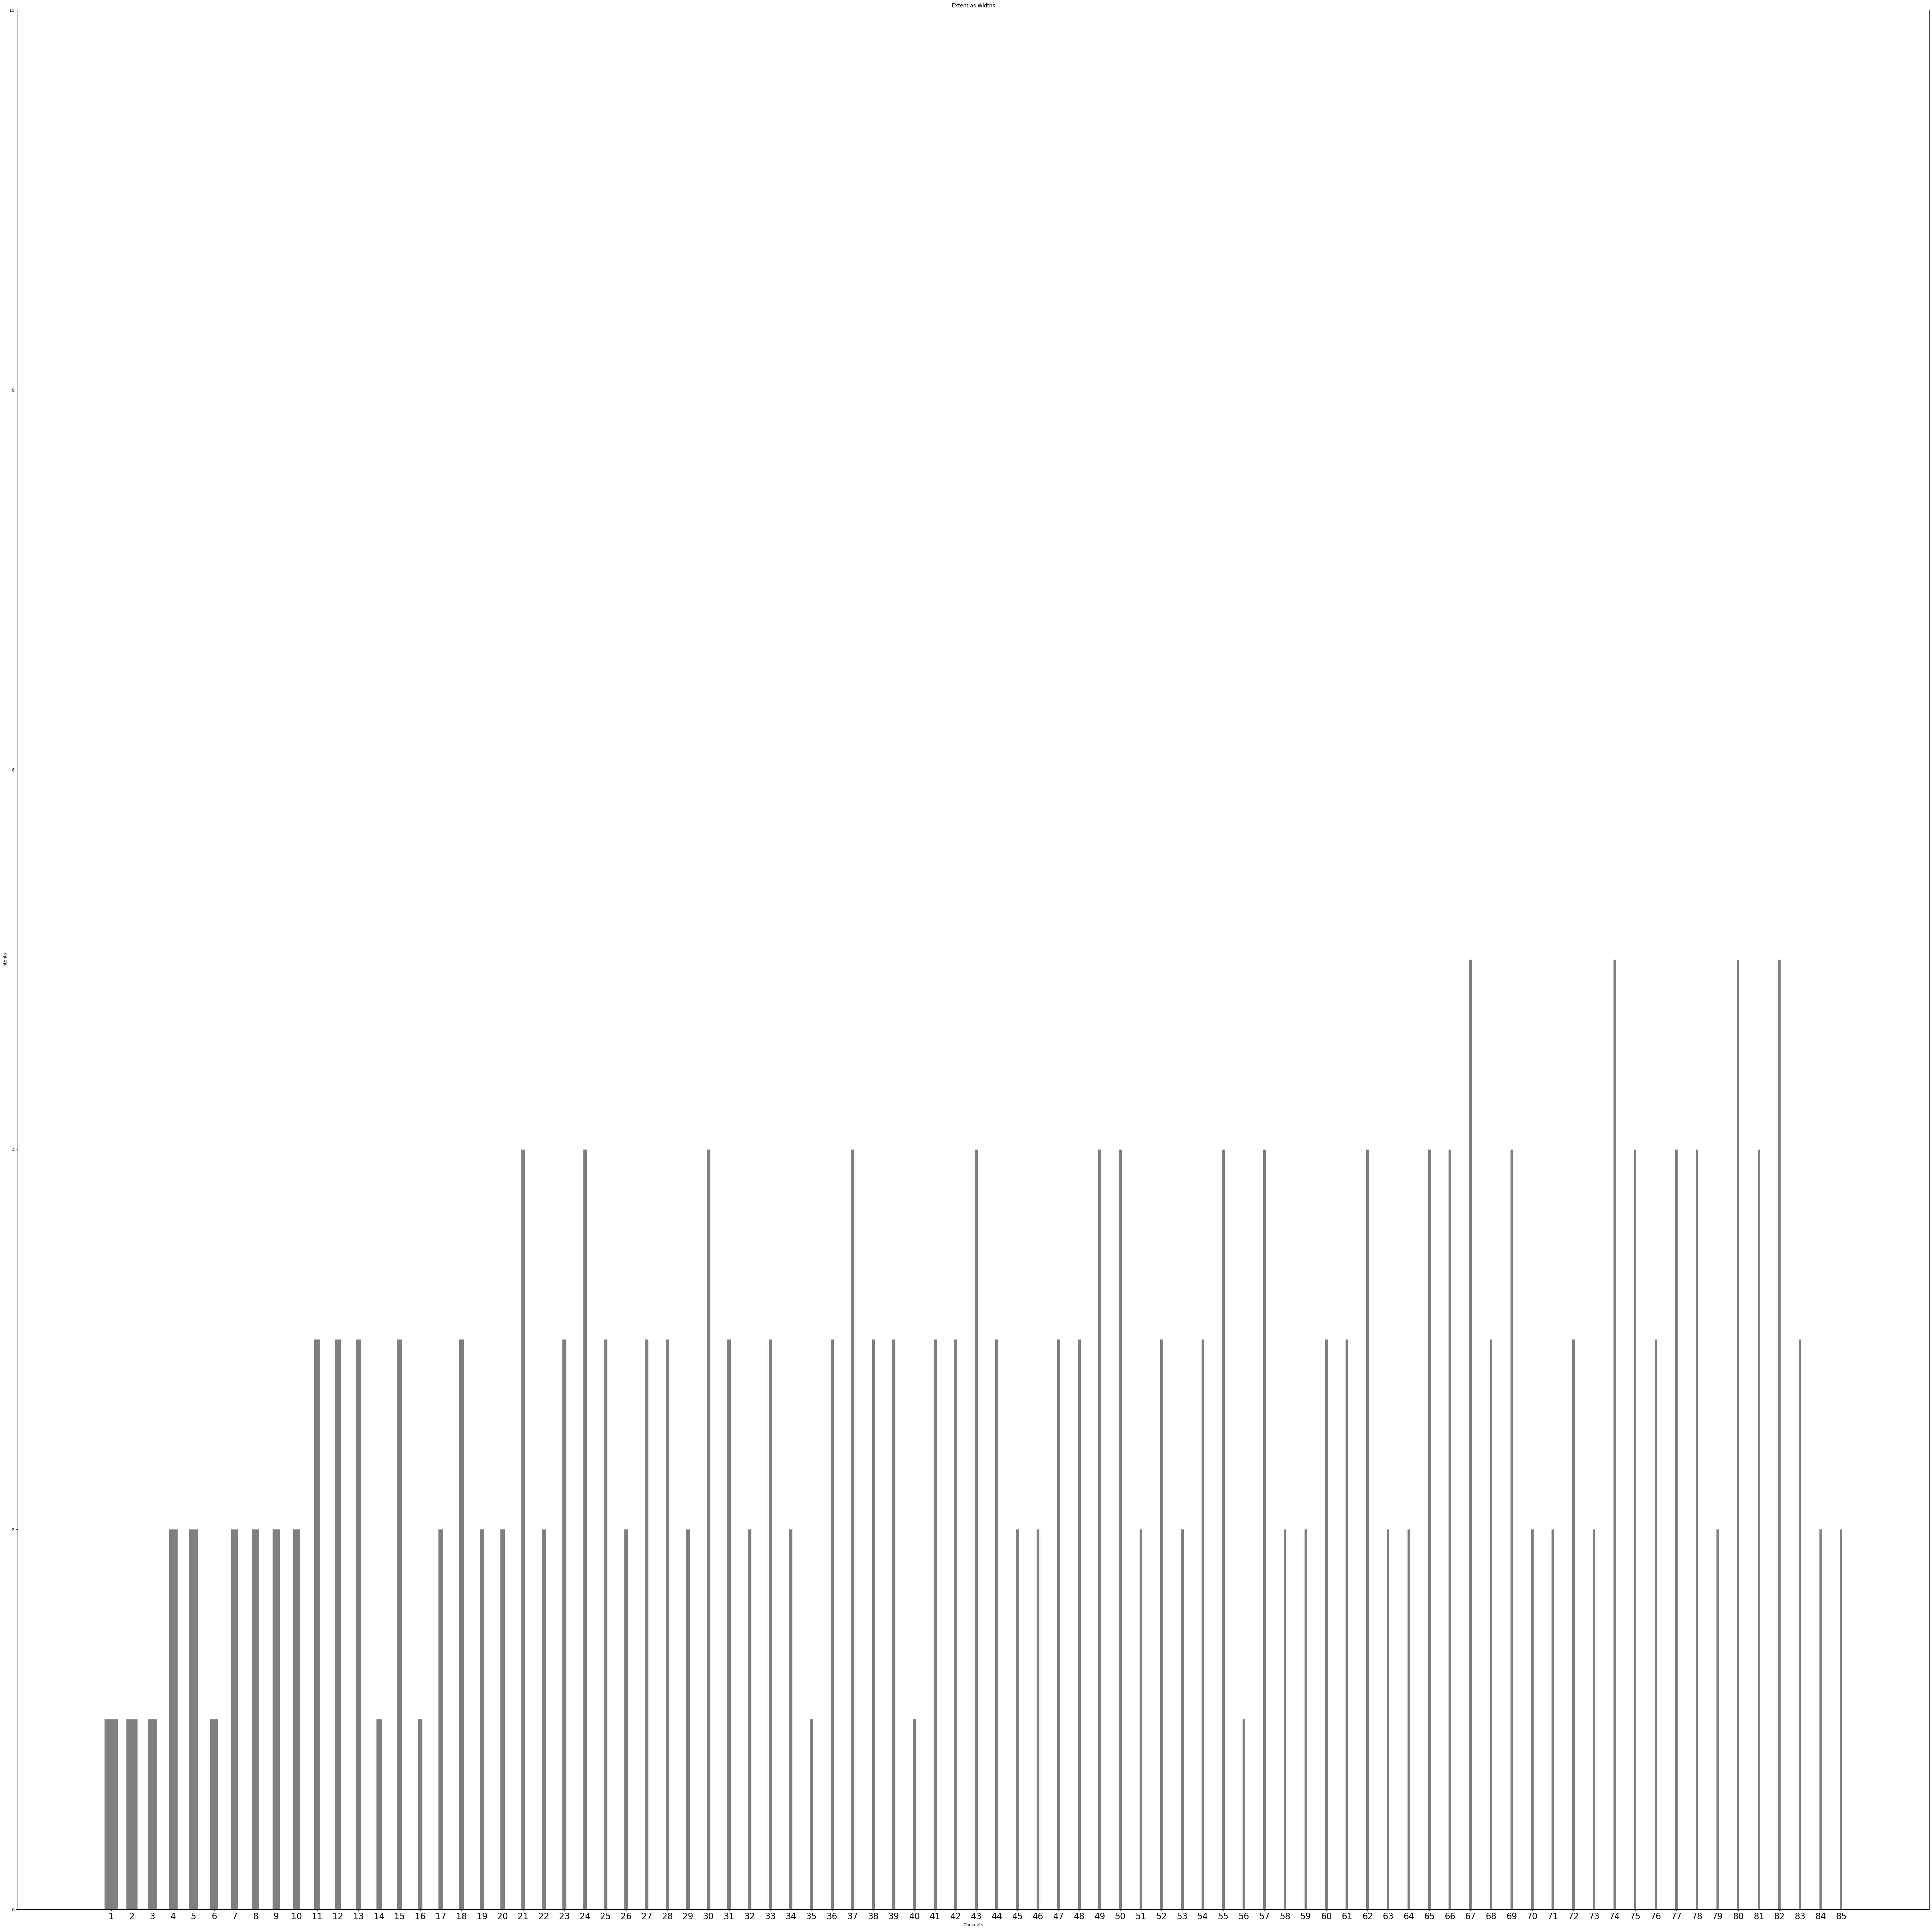

In [182]:
import numpy as np

values = y_coords
widths = x_coords  # Proportional widths

# Normalize the widths to fit within a maximum space
max_width = 1.0
normalized_widths = [w / max(widths) * max_width for w in widths]
print(normalized_widths)
# Calculate the positions of the bar centers
num_bars = len(values)
spacing = 1.5  # Equal spacing between centers
positions = np.arange(num_bars) * spacing

# Plot the bars
fig, ax = plt.subplots(figsize=(80, 80))

for i in range(num_bars):
    ax.bar(positions[i], values[i], width=normalized_widths[i], align='center', color='gray')

# Set x-ticks to be in the center of the bars
ax.set_xticks(positions)
ax.set_xticklabels([i for i in indices], fontsize=20)
ax.set_ylim(0, 10)
plt.xlabel('Concepts')
plt.ylabel('Intents')
plt.title('Extent as Widths')

plt.show()

In [184]:
# Plot the bars
fig, ax = plt.subplots(figsize=(80,80))

for i in range(num_bars):
    ax.bar(positions[i], values[i], width=normalized_widths[i], align='center', color='gray')

# Set x-ticks to be in the center of the bars
ax.set_xticks(positions)
ax.set_xticklabels([i for i in indices], fontsize=20)

# Hide the axes spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Remove the y-axis labels
ax.set_yticklabels([])
ax.set_ylim(0, 10)
# Optionally, you can also remove the y-axis ticks if desired
ax.yaxis.set_ticks_position('none')

plt.savefig('../results/barchart/to_compare.png')
plt.close()

In [186]:
# plot without grid and labels
# Plot the bars
fig, ax = plt.subplots(figsize=(80, 80))

for i in range(num_bars):
    ax.bar(positions[i], values[i], width=normalized_widths[i], align='center', color='gray')
ax.set_ylim(0, 10)
ax.axis('off')
plt.savefig('../results/barchart/to_process.png')
plt.close()

## Saliency Mapping

### Saliency Mapping Methods

#### Guided Integrated Gradients
Advanced technique used for saliency mapping, particularly in the context of neural networks and deep learning models. This method aims to improve the interpretability of model predictions by highlighting important features that influence the model's decision. Combines aspects of Integrated Gradients and Guided Backpropagation to provide a more informative and reliable saliency map. # so no need to consider those two in my opinion because this one is already better.
#### XRAI
A state-of-the-art saliency mapping technique developed to provide more intuitive and accurate explanations of model predictions by integrating area-based visualisations. It builds on the concept of integrated gradients but introduces a novel approach to ranking and aggregating areas of the input image, which enhances interpretability. It aims to produce more meaningful and human-understandable saliency maps. It achieves this by considering not just individual pixels but larger contiguous areas, thereby providing context and improving the coherence of the highlighted regions. # in my opinion it is the best for our purposes
### SmoothGrad
A technique designed to improve the visual quality and robustness of saliency maps generated by gradient-based methods. It was introduced to address the issue of noisy and less interpretable saliency maps produced by raw gradients. # but if we use XRAY we don’t have to address the problem
### Vanilla Gradients
For more robust and clearer interpretations, techniques like Integrated Gradients, SmoothGrad, or XRAI might be preferred. # to be ignored
#### Guided Backpropogation
#### Integrated Gradients
#### Grad-CAM
Provides insights by highlighting the important regions in an input image that influence the model's predictions. Unlike some other gradient-based methods, Grad-CAM focuses on the deeper layers of the network, which capture high-level features, making the generated saliency maps more interpretable and relevant to the task.


In [187]:
# Boilerplate imports.
import tensorflow as tf
import numpy as np
from PIL import Image, ImageEnhance

import saliency.core as saliency


### Utility methods

In [188]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
  if ax is None:
    plt.figure()
  plt.axis('off')
  plt.imshow(im)
  plt.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
  if ax is None:
    plt.figure()
  plt.axis('off')

  plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=1)
  plt.title(title)

def ShowHeatMap(im, title, ax=None):
  if ax is None:
    plt.figure()
  plt.axis('off')
  plt.imshow(im, cmap='inferno')
  plt.title(title)

def LoadImage(file_path):
    im = Image.open(file_path).convert('RGB')
    
    # # Resize while maintaining aspect ratio
    # im.thumbnail((224, 224), Image.Resampling.LANCZOS)
    
    # # Create a new image with the target size and a white background
    # new_im = Image.new('RGB', (224, 224), (255, 255, 255))
    
    # # Paste the resized image onto the center of the new image
    # new_im.paste(im, ((224 - im.width) // 2, (224 - im.height) // 2))
    
    # im = np.asarray(new_im)
    im = im.resize((224,224))
    im = np.asarray(im)
    return im

def PreprocessImage(im):
  im = tf.keras.applications.vgg16.preprocess_input(im)
  return im

In the documentation they provide an example with the VGG16/VGG19 image classification model. They are deep convolutional neural networks with 16 and 19 layers, respectively. They are known for their simplicity and effectiveness in image classification tasks.

In [189]:
m = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
conv_layer = m.get_layer('block5_conv3')
model = tf.keras.models.Model(inputs=m.input, outputs=[conv_layer.output, m.output])

class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            _, output_layer = model(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

Prediction class: 916
Prediction class: 549
Prediction class: 677


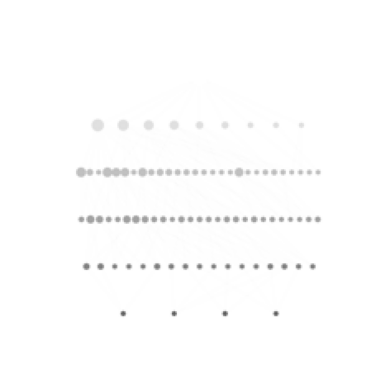

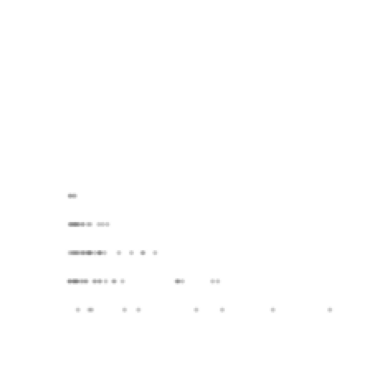

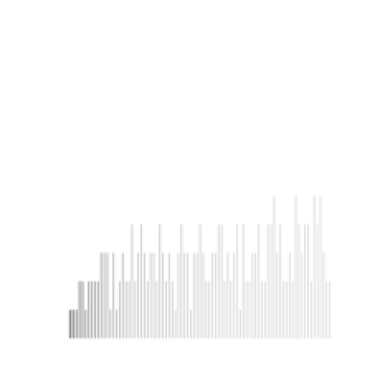

In [190]:
charts = ['lattice', 'scatterplot', 'barchart']
percentages = [1, 50, 100]

for chart in charts:
# Load the image
    im_orig = LoadImage(f'../results/{chart}/to_process.png')
    im = PreprocessImage(im_orig)

    # Show the image
    ShowImage(im_orig)

    _, predictions = model(np.array([im]))
    prediction_class = np.argmax(predictions[0])
    call_model_args = {class_idx_str: prediction_class}

    print("Prediction class: " + str(prediction_class))

Let's see how are the outputs of different saliency methods.

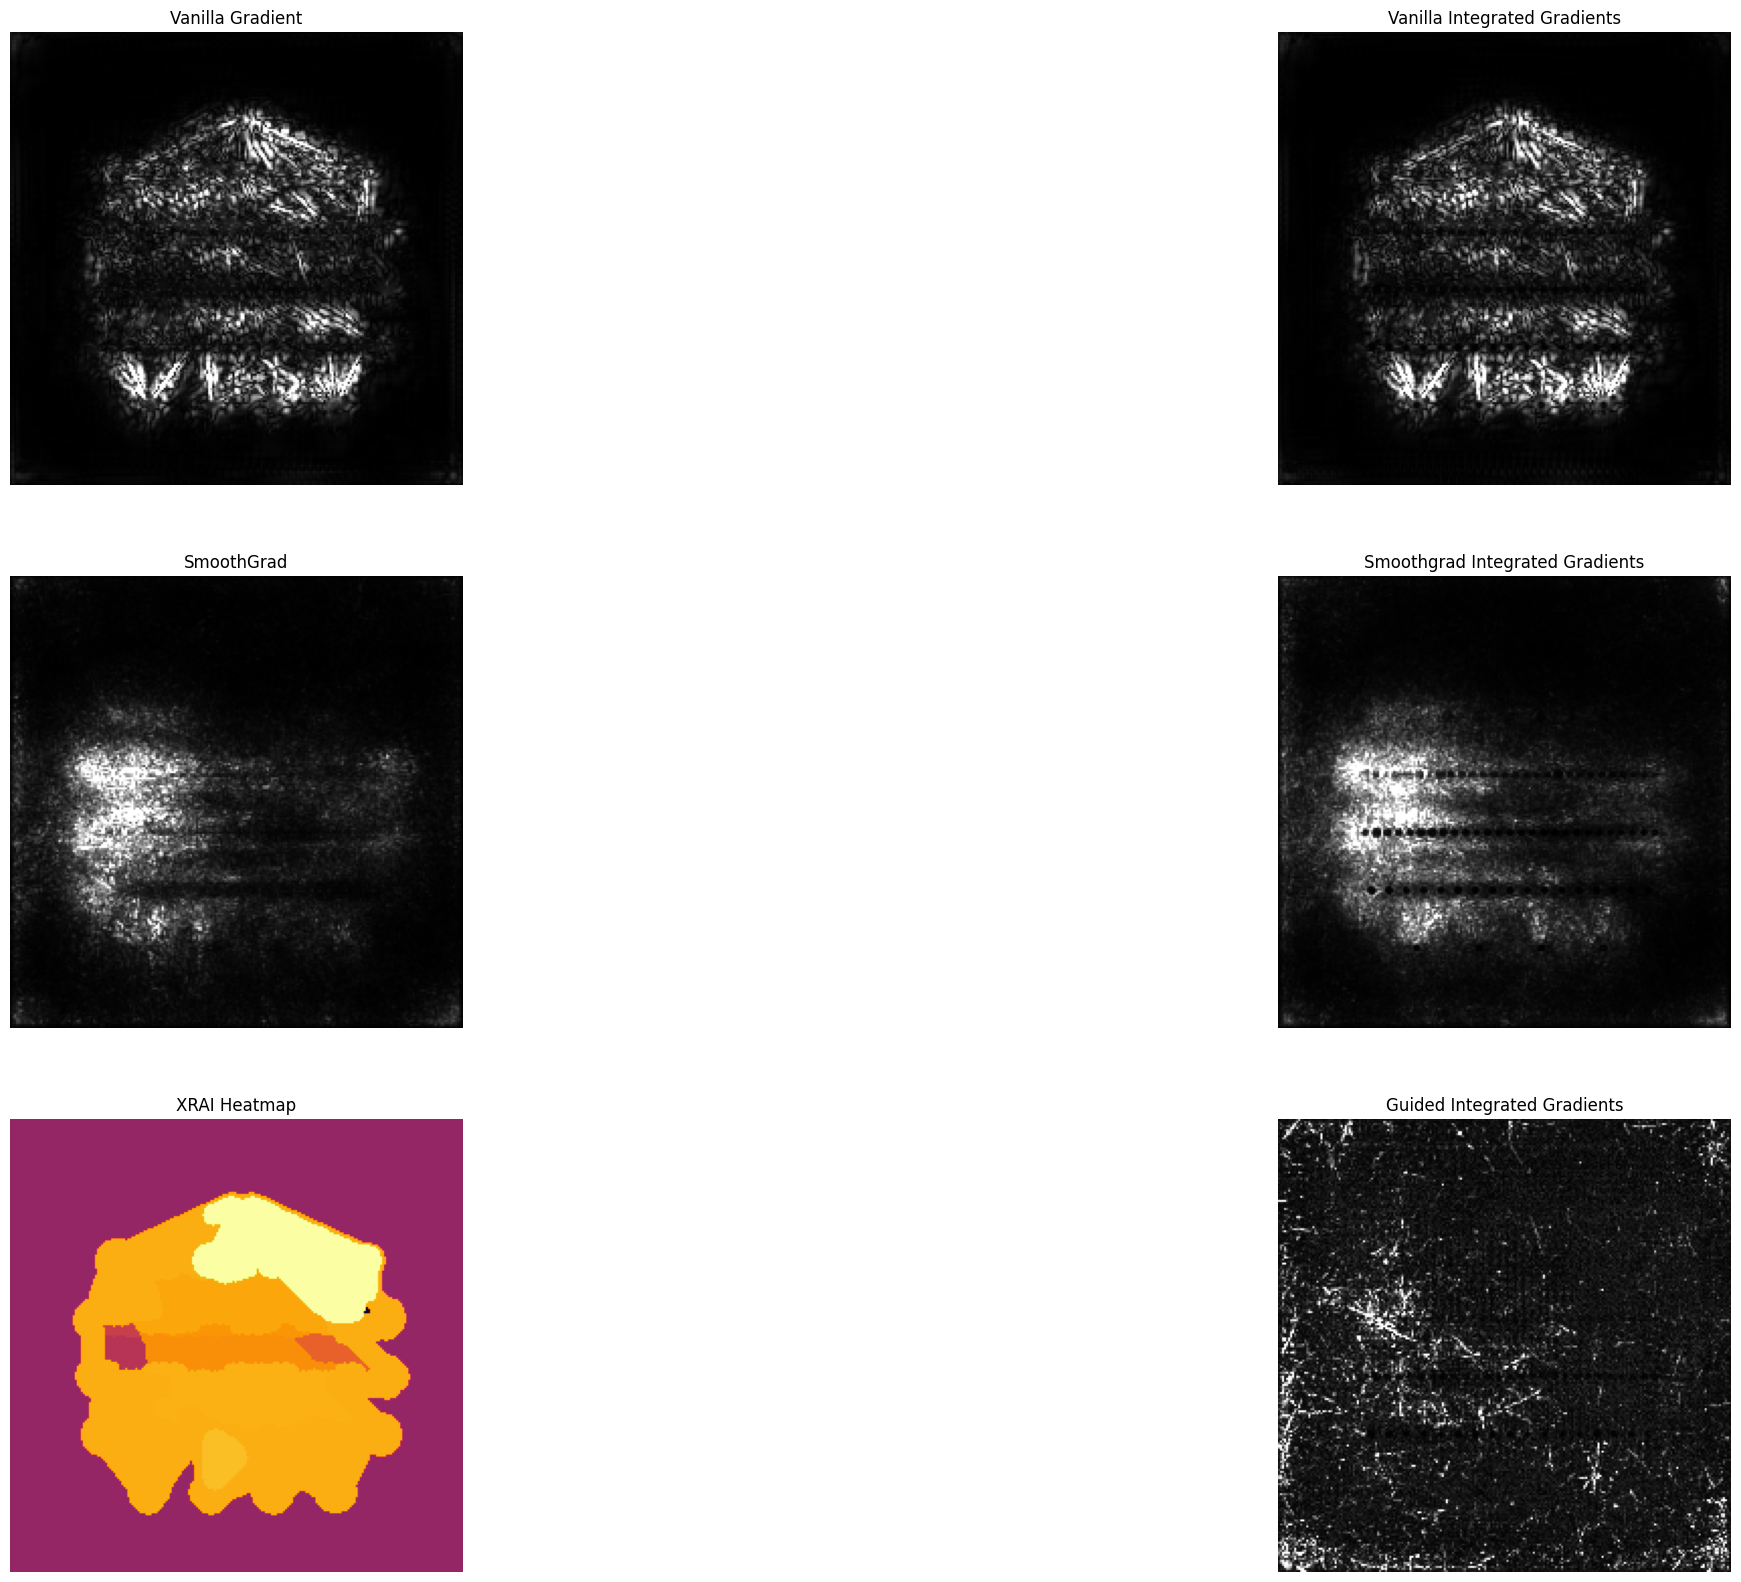

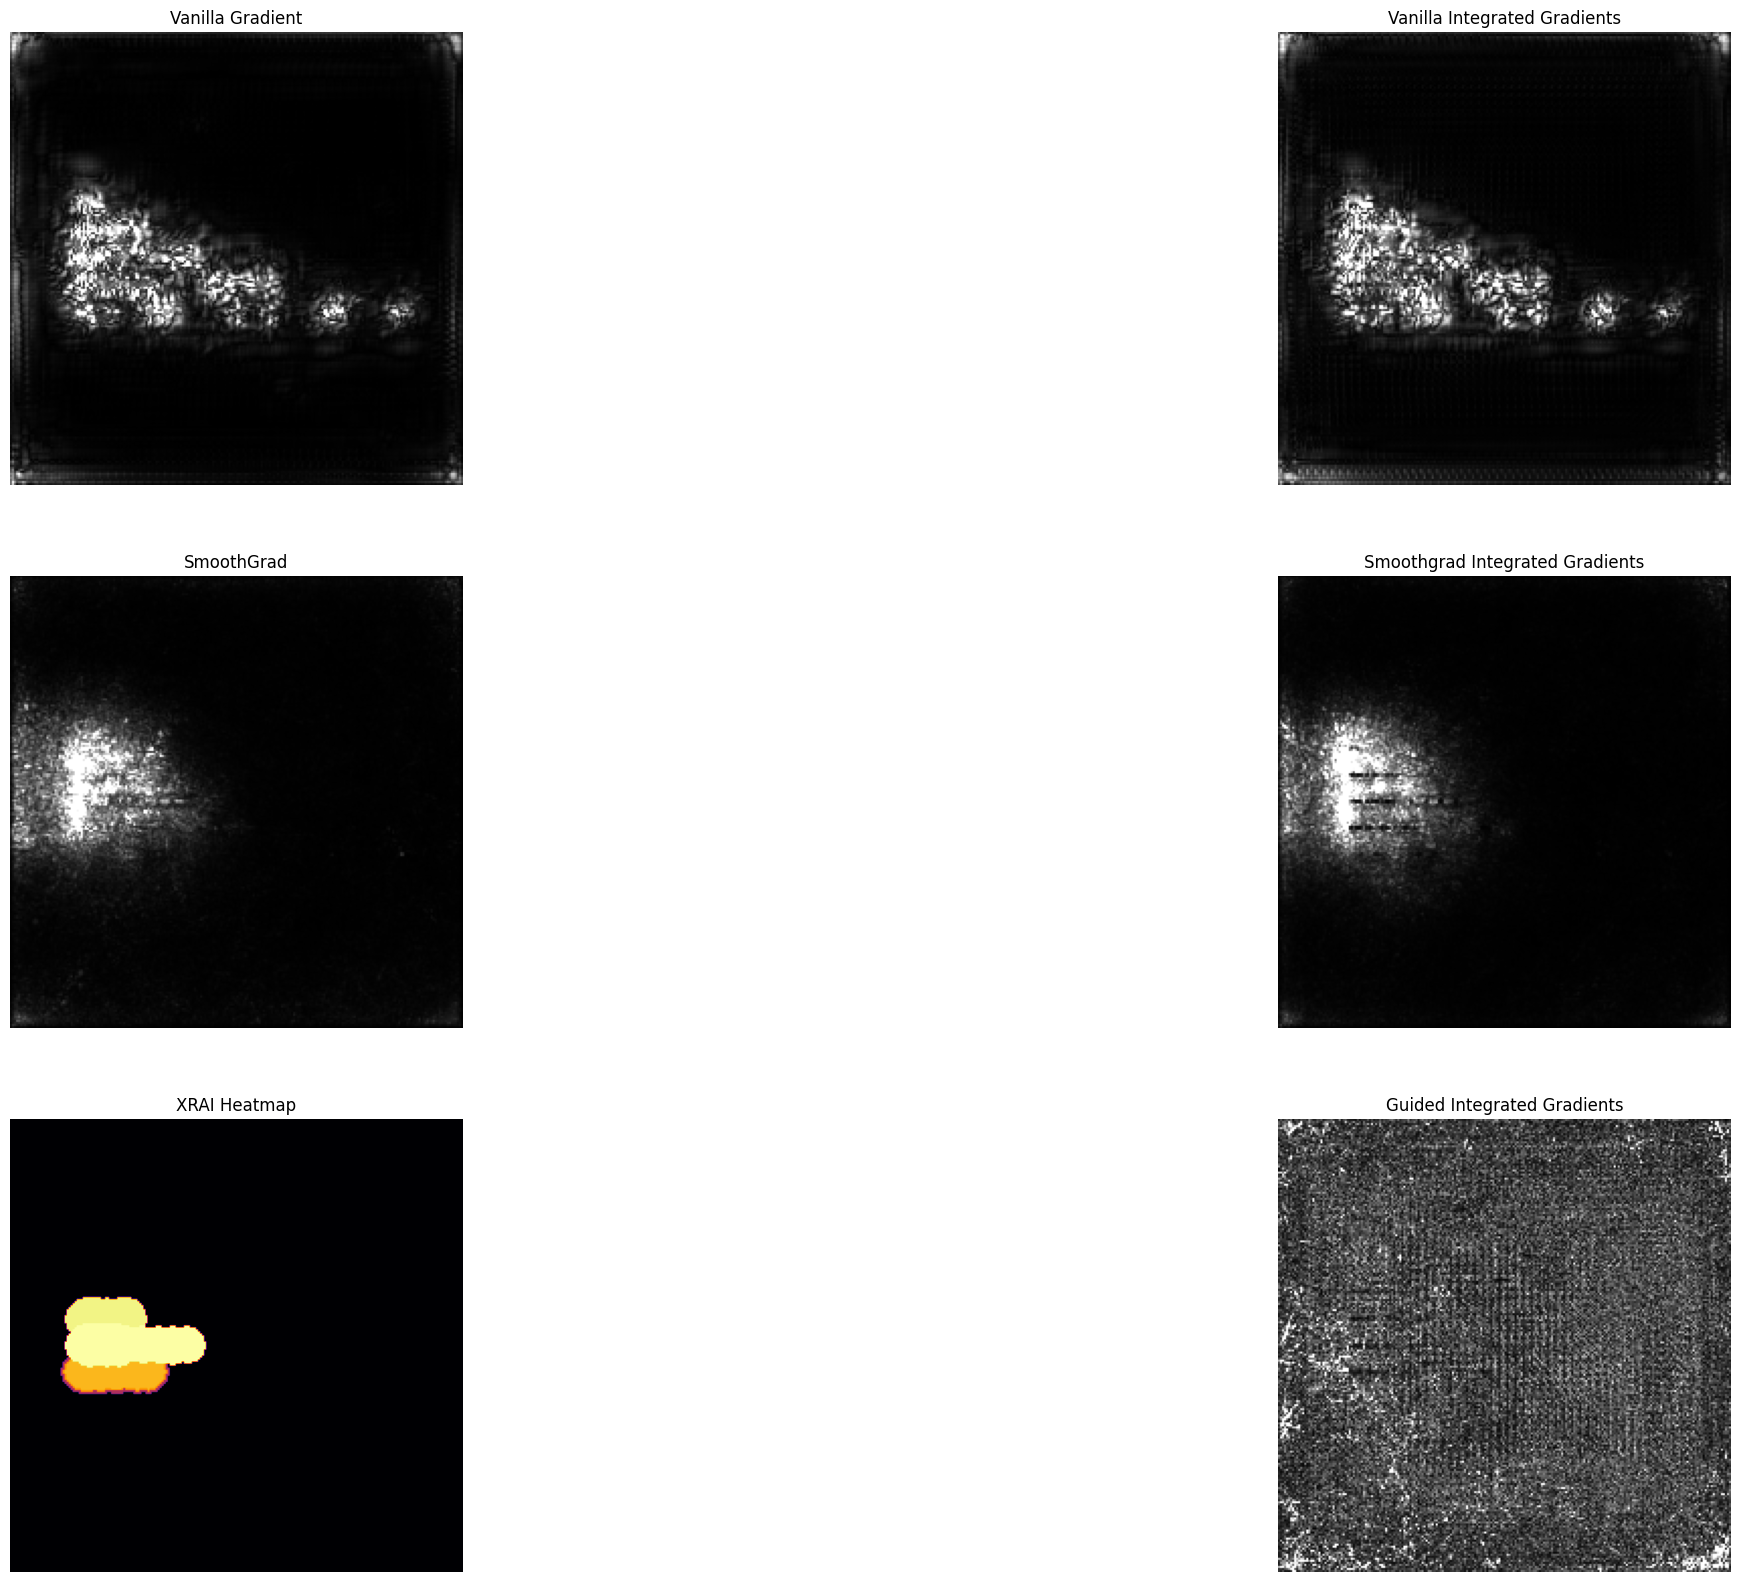

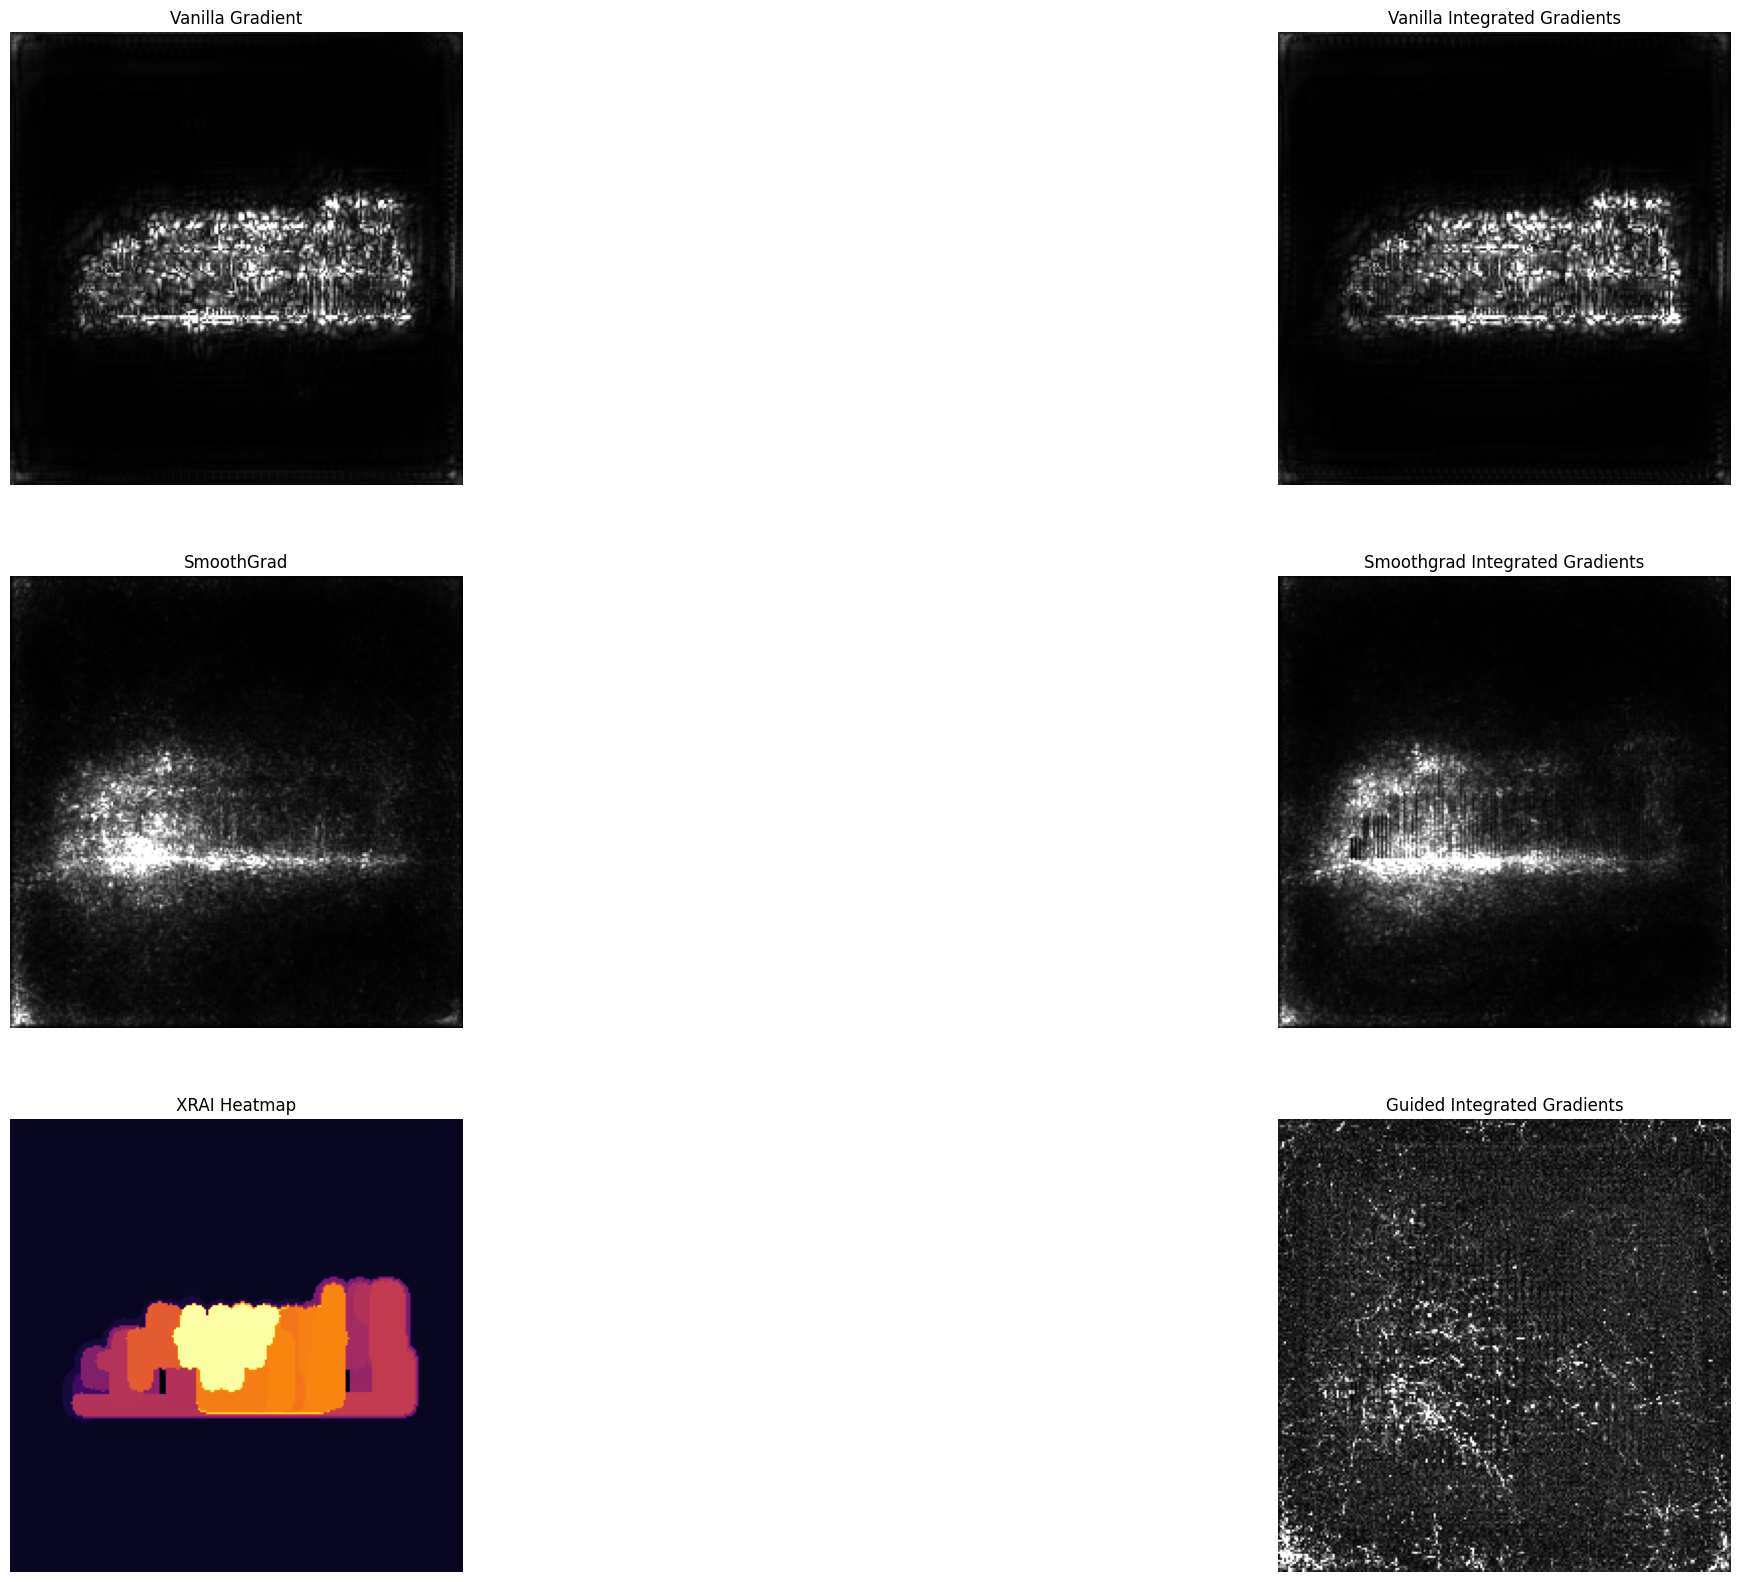

In [135]:
for chart in charts:
# Load the image
    im_orig = LoadImage('../results/'+chart+'/to_process.png')
    im = PreprocessImage(im_orig)

    # Set up matplot lib figures.
    ROWS = 3
    COLS = 2
    UPSCALE_FACTOR = 10
    plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

    # Construct the saliency object. This alone doesn't do anthing.
    gradient_saliency = saliency.GradientSaliency()
    integrated_gradients = saliency.IntegratedGradients()
    xrai_object = saliency.XRAI()
    guided_ig = saliency.GuidedIG()

    # Baseline is a black image.
    baseline = np.zeros(im.shape)

    # compute masks
    vanilla_mask_3d = gradient_saliency.GetMask(im, call_model_function, call_model_args)
    smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im, call_model_function, call_model_args)
    vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
    im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
    # Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
    smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
    im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
    xrai_attributions = xrai_object.GetMask(im, call_model_function, call_model_args, batch_size=20)
    guided_ig_mask_3d = guided_ig.GetMask(im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, max_dist=1.0, fraction=0.5)

    # Call the visualization methods to convert the 3D tensors to 2D grayscale.
    vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
    smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)
    integrated_vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
    integrated_smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)
    guided_ig_mask_grayscale = saliency.VisualizeImageGrayscale(guided_ig_mask_3d)

    # Render the saliency masks.
    ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=plt.subplot(ROWS, COLS, 1))
    ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=plt.subplot(ROWS, COLS, 3))
    ShowGrayscaleImage(integrated_vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=plt.subplot(ROWS, COLS, 2))
    ShowGrayscaleImage(integrated_smoothgrad_mask_grayscale, title='Smoothgrad Integrated Gradients', ax=plt.subplot(ROWS, COLS, 4))
    ShowHeatMap(xrai_attributions, title='XRAI Heatmap', ax=plt.subplot(ROWS, COLS, 5))
    ShowGrayscaleImage(guided_ig_mask_grayscale, title='Guided Integrated Gradients', ax=plt.subplot(ROWS, COLS, 6))

    plt.savefig('../results/'+chart+'/all_saliency_methods.png', bbox_inches='tight', pad_inches=0)

I choose 3 methods: Vanilla Integrated gradient, Smooth Integrated Gradient and XRAI Heatmap.
But first I need to create a function that computes images based on percentages.

In [191]:
def compute_pecentile(im_origin, perc, saliency_mask):
    total = 100
    mask = saliency_mask >= np.percentile(saliency_mask, total-perc)
    im_mask = np.array(im_origin)
    im_mask[~mask] = 0
    return im_mask

### Vanilla Integrated gradient

<Figure size 1000x1000 with 0 Axes>

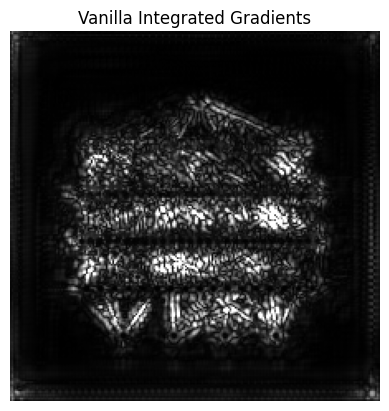

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

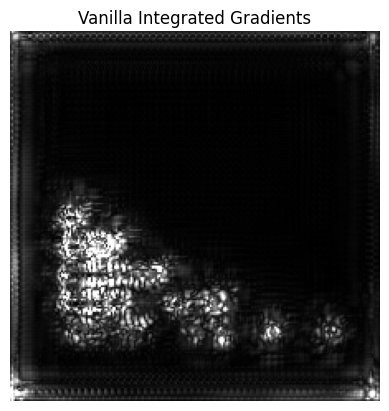

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

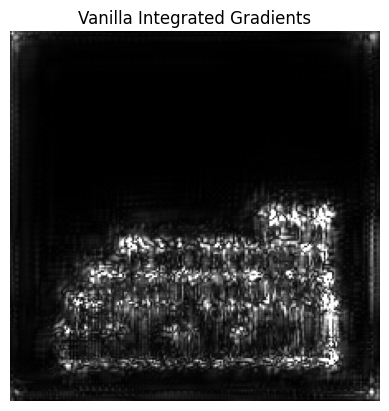

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [192]:
for chart in charts:
# Load the image
    im_orig = LoadImage('../results/'+chart+'/to_process.png')
    im = PreprocessImage(im_orig)

    # Set up matplot lib figure
    plt.figure(figsize=figsize)

    # Construct the saliency object
    integrated_gradients = saliency.IntegratedGradients()

    # Baseline is a black image.
    baseline = np.zeros(im.shape)

    # compute mask
    vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)

    # Call the visualization methods to convert the 3D tensors to 2D grayscale.
    integrated_vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)

    # Render the saliency masks.
    ShowGrayscaleImage(integrated_vanilla_mask_grayscale, title='Vanilla Integrated Gradients')

    plt.savefig(f'../results/{chart}/vanilla_integrated_grad.png', bbox_inches='tight', pad_inches=0)

    for perc in percentages:
        plt.figure(figsize=figsize)
        new_mask = compute_pecentile(im_orig, perc, integrated_vanilla_mask_grayscale)
        ShowImage(new_mask)
        plt.savefig(f'../results/{chart}/VIG_top_{str(perc)}.png', bbox_inches='tight', pad_inches=0)
        plt.close()

### Smooth Integrated Gradient

<Figure size 1000x1000 with 0 Axes>

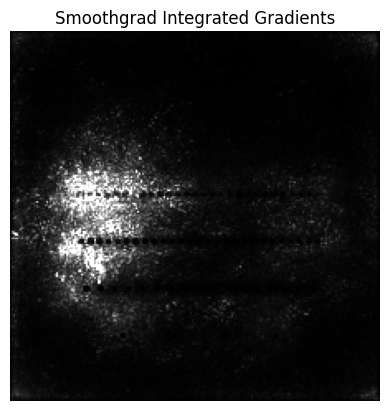

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

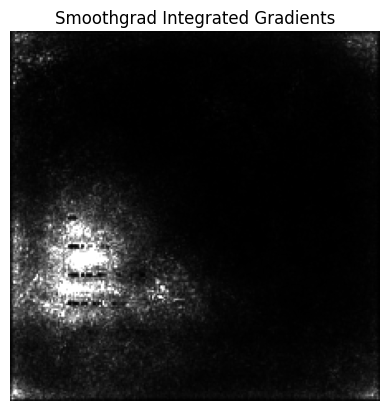

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

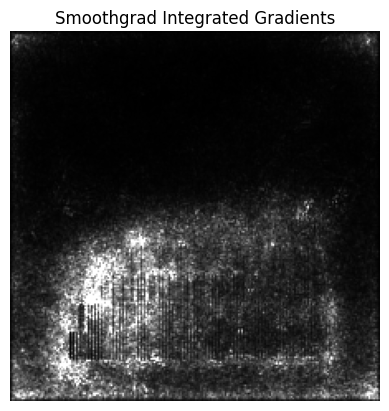

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [193]:
for chart in charts:
# Load the image
    im_orig = LoadImage('../results/'+chart+'/to_process.png')
    im = PreprocessImage(im_orig)

    # Set up matplot lib figure
    plt.figure(figsize=figsize)

    # Construct the saliency object
    integrated_gradients = saliency.IntegratedGradients()

    # Baseline is a black image.
    baseline = np.zeros(im.shape)

    # compute mask
    smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)

    # Call the visualization methods to convert the 3D tensors to 2D grayscale.
    smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)

    # Render the saliency masks.
    ShowGrayscaleImage(smoothgrad_mask_grayscale, title='Smoothgrad Integrated Gradients')

    plt.savefig(f'../results/{chart}/smooth_integrated_grad.png', bbox_inches='tight', pad_inches=0)

    for perc in percentages:
        plt.figure(figsize=figsize)
        new_mask = compute_pecentile(im_orig, perc, smoothgrad_mask_grayscale)
        ShowImage(new_mask)
        plt.savefig(f'../results/{chart}/SIG_top_{str(perc)}.png', bbox_inches='tight', pad_inches=0)
        plt.close()

### XRAI Heatmap

<Figure size 1000x1000 with 0 Axes>

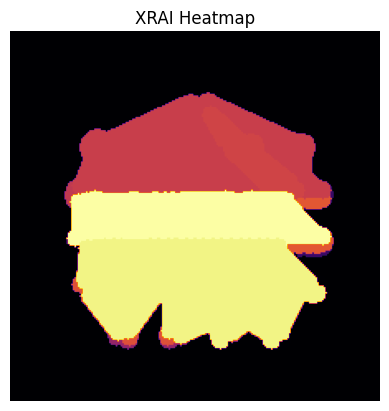

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

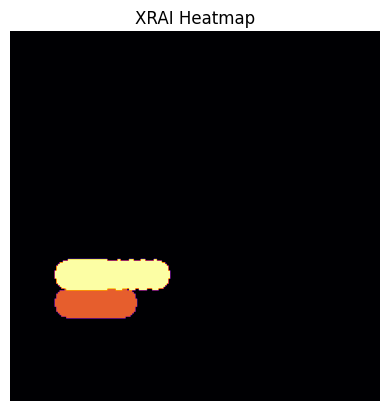

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

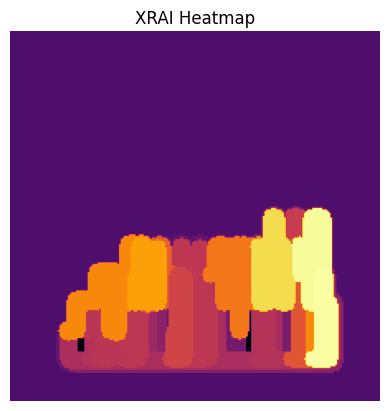

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [211]:
for chart in charts:
# Load the image
    im_orig = LoadImage('../results/'+chart+'/to_process.png')
    im = PreprocessImage(im_orig)

    # Set up matplot lib figure
    plt.figure(figsize=figsize)

    # Construct the saliency object
    xrai_object = saliency.XRAI()

    # compute mask
    xrai_attributions = xrai_object.GetMask(im, call_model_function, call_model_args, batch_size=20)

    # Render the saliency mask
    ShowHeatMap(xrai_attributions, title='XRAI Heatmap')

    plt.savefig(f'../results/{chart}/xray.png', bbox_inches='tight', pad_inches=0)

    for perc in percentages:
        plt.figure(figsize=figsize)
        new_mask = compute_pecentile(im_orig, perc, xrai_attributions)
        ShowImage(new_mask)
        plt.savefig(f'../results/{chart}/XRAY_top_{str(perc)}.png', bbox_inches='tight', pad_inches=0)
        plt.close()

### Compare Input and Output Images

In [214]:
saliency_methods = ['VIG', 'SIG', 'XRAY']
for chart in charts:
    input_image = Image.open(f'../results/{chart}/to_compare.png')
    for method in saliency_methods:
        for perc in percentages:
            output_image = Image.open(f'../results/{chart}/{method}_top_{str(perc)}.png')

            # Resize the input image to match the dimensions of the output image
            input_image_resized = input_image.resize(output_image.size, Image.Resampling.LANCZOS)

            # Convert both images to RGBA
            input_image_resized = input_image_resized.convert('RGBA')
            output_image = output_image.convert('RGBA')

            # Enhance the visibility of the output image by adjusting its contrast (if needed)
            enhancer = ImageEnhance.Contrast(output_image)
            output_image = enhancer.enhance(2.0)

            # Create a blended image for visualization
            blended_image = Image.blend(input_image_resized, output_image, alpha=0.5)

            # Display the blended image
            fig, ax = plt.subplots(figsize=figsize)

            ax.imshow(blended_image)
            ax.axis('off')


            plt.savefig(f'../results/{chart}/{method}_overaly_{str(perc)}_percent.png', bbox_inches='tight')
            plt.close()

## Data Analysis

In [62]:
import json

saliency_results = '../results/saliency_results.json'

with open(saliency_results, 'r') as file:
    data = json.load(file)

temp_data = data['lattice']

one_percent_lists = []
hundred_percent_lits = []

for method in saliency_methods:
    one_percent_lists.append(temp_data[method]['01'])
    hundred_percent_lits.append(temp_data[method]['100'])
print('ONE PERCENT', one_percent_lists)
print('ONE HUNDRED PERCENT', hundred_percent_lits)

ONE PERCENT [[0, 1, 2, 3, 6, 56, 4, 20, 44, 74, 82], [4, 20, 64, 5, 8, 10, 44, 11, 15, 39, 47, 13, 21], [21, 24, 74]]
ONE HUNDRED PERCENT [[25, 60, 31, 27, 54, 36, 38, 81, 69], [0, 35, 54, 27, 31, 60, 25, 50, 78, 66, 81, 69, 80, 57], [0, 70, 7, 38, 36, 54, 27, 31]]


Find common elments for **lattice**

In [43]:
# Converting the first list to a set
one_percent_common_elements = set(one_percent_lists[0])

# Iteratively finding the intersection with other lists
for lst in one_percent_lists[1:]:
    one_percent_common_elements.intersection_update(lst)

# Converting the set back to a list (if needed)
# common_elements_list = list(one_percent_common_elements)

# Displaying the common elements
print('ONE PERCENT', one_percent_common_elements)

ONE PERCENT set()


In [44]:
# Converting the second list to a set
hundred_percent_common_elements = set(hundred_percent_lits[0])

# Iteratively finding the intersection with other lists
for lst in hundred_percent_lits[1:]:
    hundred_percent_common_elements.intersection_update(lst)

# Converting the set back to a list (if needed)
# common_elements_list = list(hundred_percent_common_elements)

# Displaying the common elements
print('ONE HUNDRED PERCENT', hundred_percent_common_elements)

ONE HUNDRED PERCENT {27, 54, 31}


It seems that there are no common concepts for the lattice based on the three saliency methods.

Save attributes and artworks number into a file.

In [63]:
artworks_info = 'https://raw.githubusercontent.com/SPARQL-Anything/showcase-tate/main/arts-and-subjects-list.csv'
artworks_info_df = pd.read_csv(artworks_info)

In [91]:
final_dict = {
    '01': {},
    '100': {}
}

for method in saliency_methods:
    one_percent_concept = temp_data[method]['01']
    hundred_percent_concept = temp_data[method]['100']
    for i, c in enumerate(L):
        if len(c.intent) !=0 and len(c.extent) !=0:
            artworks_dict = {}
            if i in one_percent_concept:
                artwork_ids = c.extent
                for id in artwork_ids:
                    artworks_dict[id] = ''
                final_dict['01'][str(c.intent)] = artworks_dict
            elif i in hundred_percent_concept:
                artwork_ids = c.extent
                for id in artwork_ids:
                    artworks_dict[id] = ''
                final_dict['100'][str(c.intent)] = artworks_dict

final_file = '../results/final_results.json'
with open(final_file, 'w') as file:
    json.dump(final_dict, file)

In [96]:
with open(final_file, 'r') as file:
    final_data = json.load(file)

for perc, con in final_data.items():
    for middle_key, middle_value in con.items():
        for inner_key, inner_value in middle_value.items():
            title = artworks_info_df.loc[artworks_info_df['id'] == int(inner_key), 'title'].values[0]
            middle_value[inner_key] = title

final_file_titles = '../results/final_results_titles.json'
with open(final_file_titles, 'w') as file:
    json.dump(final_data, file)

            


Check if there are artworks in common.

In [67]:
one_common_artworks = []
hundred_common_artworks = []

for method in saliency_methods:
    one_percent_concept = temp_data[method]['01']
    hundred_percent_concept = temp_data[method]['100']

    one_percent_artworks = []
    hundred_percent_artworks = []

    for i, c in enumerate(L):
        if i in one_percent_concept:
            artwork_ids = list(c.extent)
            one_common_artworks.append(artwork_ids)
        elif i in hundred_percent_concept:
            artwork_ids = list(c.extent)
            hundred_common_artworks.append(artwork_ids)

# Converting the first list to a set
one_percent_common_elements = set(one_common_artworks[0])

# Iteratively finding the intersection with other lists
for lst in one_common_artworks[1:]:
    one_percent_common_elements.intersection_update(lst)


# Displaying the common elements
print('ONE PERCENT', one_percent_common_elements)

# Converting the second list to a set
hundred_percent_common_elements = set(hundred_common_artworks[0])

# Iteratively finding the intersection with other lists
for lst in hundred_common_artworks[1:]:
    hundred_percent_common_elements.intersection_update(lst)


# Displaying the common elements
print('ONE HUNDRED PERCENT', hundred_percent_common_elements)

ONE PERCENT {'17168', '15176', '19699', '15506', '15055', '15050', '17186', '19814', '19803', '15225', '15177', '19815', '15188', '17187', '20101', '15051', '19697', '15189', '17167', '15440'}
ONE HUNDRED PERCENT set()


Retrieve arworks titles and their subjects

In [72]:
for artworkId in one_percent_common_elements:
    title = artworks_info_df.loc[artworks_info_df['id'] == int(artworkId), 'title'].values[0]
    subjects = artworks_info_df.loc[artworks_info_df['id'] == int(artworkId), 'subjects'].values[0]
    print(artworkId, title, subjects)

17168 Dartmouth 161 247 983 7979 5212 195 636 496 2803 557 1558 115 114 113 112 1865 2355 97 95 1138 1236 495 106 145 13 60 91 76 71 73 7977 20 28 27 799
15176 Dartmouth Cove 602 1236 495 3617 20 19 28 2942 636 496 1558 106 91 78 145 13 60 47 116 4479 5009 263 555 2076 1138 2597 14746 2388 180 128 3023 2803 1635 161 160 157 685 177 178 95 175 3557 13637 48 7978 170 82 169 76 71 67 73 9262 1266 2355 557 1191 544 998 7977 115 114 113 112 195 167
19699 Falmouth Harbour, Cornwall, engraved by W.B. Cooke 694 48 53 5009 3011 989 1138 106 78 145 13 60 47 91 10065 549 3557 2803 161 16370 8203 636 1347 6644 97 95 92 1236 558 1518 557 1516 799 77 73 76 71 9169 1865 2355 195 167 112 114 113 115 20 28 170 80
15506 Falmouth 636 1937 161 1347 175 95 5009 2575 20 28 195 167 9169 16174 90 170 83 989 1236 1865 2355 1163 1516 16370 3529 12084 1792 1106 112 114 113 115 119 1518 2803 1138 106 78 145 13 60 116 91 77 76 73 71 70 6070
15055 Falmouth Harbour, Cornwall 989 2803 549 3557 161 77 73 76 71 112 114